<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/content/drive/.shortcut-targets-by-id/1tHYgEz3lQF-LmtFPXRgMBDh4UN54qeAs/datas


In [2]:
# !unzip -o ./mpie_30_shuffle.zip -d ./mpie_30_shuffle

In [3]:
!ls

dataCh4_7.mat		iris_shuffle.mat	 mpie_30_shuffle
dataCh4_7.zip		iris.zip		 mpie_30_shuffle.zip
digitimages_binary.zip	matlab_iris_shuffle.mat  number_images


##Load Dataset

In [4]:
path = path_root + 'mpie_30_shuffle/'

def loadDatasetFromCSV(_datafilename, _labelfilename, label_column):
  _train_feature_csv = pd.read_csv(path + _datafilename, dtype=np.float32, header=None) # image features of train data
  _train_feature_flatten = _train_feature_csv.values.flatten()
  _train_feature_reshape = np.reshape(_train_feature_flatten, (_train_feature_csv.shape[0], 32,-1))

  _train_label_csv = pd.read_csv(path + _labelfilename, dtype=np.float32, header=None) # labels of train data
  _train_label = _train_label_csv[label_column] # get label you want

  return _train_feature_reshape, _train_label

In [5]:
import pandas as pd
import numpy as np

# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', 0)
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', 0)

train_feature_reshape.shape, train_label.shape, validation_feature_reshape.shape, validation_label.shape

((18777, 32, 32), (18777,), (5086, 32, 32), (5086,))

In [6]:
import tensorflow as tf

def preprocessDataset(features_reshape, labels, batch_size=64, shuffle_buffer_size=100):
  _batch_size = batch_size
  _shuffle_buffer_size = shuffle_buffer_size

  _features = features_reshape
  _labels = labels
  _dataset_tensors = tf.data.Dataset.from_tensor_slices((_features, _labels))

  if _shuffle_buffer_size == None:
    _dataset_tensors = _dataset_tensors.batch(_batch_size)
  else :
    _dataset_tensors = _dataset_tensors.shuffle(_shuffle_buffer_size).batch(_batch_size)

  return _dataset_tensors

In [7]:
train_dataset = preprocessDataset(train_feature_reshape, train_label)

In [8]:
# train_dataset?

In [9]:
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

###Deep CNN with BatchNormalization

In [10]:
filters = 32
_filters = filters
_min_filters = 16
_hidden_layers = int(_filters / _min_filters)
for layer in range(_hidden_layers):
  print(f'decrease : {_filters}')
  _filters = int(_filters/2)
  if _filters < _min_filters:
    break

for layer in range(_hidden_layers):
  _filters = int(_filters*2)
  if _filters > filters:
    break
  print(f'increase : {_filters}')


decrease : 32
decrease : 16
increase : 16
increase : 32


In [11]:
from tensorflow.keras import layers

category_count = train_label.unique().shape[0]
def make_cnn(filters=16, _padding='same', _kernel_initializer='he_normal', _activation='relu', _kernel_size = (3,3), _strides = (1,1), BatchNormal=False, _pool_size = (2,2)):
    model = tf.keras.Sequential()

    _filters = filters
    _min_filters = 16
    _hidden_layers = int(_filters / _min_filters)

    for layer in range(_hidden_layers):
      model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size, strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
      model.add(layers.Activation(_activation))
      if BatchNormal:
        model.add(layers.BatchNormalization())
      model.add(layers.MaxPooling2D(pool_size = _pool_size))

      _filters = int(_filters/2)
      if _filters < _min_filters:
        break

    for layer in range(_hidden_layers):
      _filters = int(_filters*2)
      if _filters > filters:
        break
      model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size, strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
      model.add(layers.Activation(_activation))
      if BatchNormal:
        model.add(layers.BatchNormalization())
      model.add(layers.MaxPooling2D(pool_size = _pool_size))

    # prior layer should be flattend to be connected to dense layers
    model.add(layers.Flatten())
    # dense layer with 50 neurons
    model.add(layers.Dense(128, activation = _activation, kernel_initializer=_kernel_initializer))
    model.add(layers.Dropout(0.5))
    # final layer with 10 neurons to classify the instances
    model.add(layers.Dense(category_count, activation = 'softmax', kernel_initializer=_kernel_initializer))

    # adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [12]:
len(list(train_dataset)) / 128

2.296875

###callback function for fit time

In [13]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()

### fit model

In [14]:
_epochs = 10
# _batch_size = len(list(train_dataset)) / 128
_batch_size = len(list(train_dataset))

def model_fit(_param):
  tf.keras.backend.clear_session()

  model = make_cnn(**_param)
  history = model.fit(train_dataset, epochs=_epochs, validation_data=validation_dataset, callbacks=[time_callback], steps_per_epoch=_batch_size)
  execution_time = sum(time_callback.times)
  return model, history, execution_time

### fit with multi params
filters : larger than 16

In [ ]:
params = [
          {'filters':16 , '_padding':'same', '_kernel_initializer':None, '_activation':'relu', '_kernel_size': (3,3), '_strides': (1,1), 'BatchNormal':False, '_pool_size': (2,2)},
          {'filters':16 , '_padding':'same', '_kernel_initializer':'he_normal', '_activation':'relu', '_kernel_size': (3,3), '_strides': (1,1), 'BatchNormal':False, '_pool_size': (2,2)},
          {'filters':16 , '_padding':'same', '_kernel_initializer':'he_normal', '_activation':'relu', '_kernel_size': (3,3), '_strides': (1,1), 'BatchNormal':True, '_pool_size': (2,2)},
          # {'filters':64 , '_padding':'same', '_kernel_initializer':None, '_activation':'relu', '_kernel_size': (3,3), '_strides': (1,1), 'BatchNormal':False, '_pool_size': (2,2)},
          # {'filters':64 , '_padding':'same', '_kernel_initializer':'he_normal', '_activation':'relu', '_kernel_size': (3,3), '_strides': (1,1), 'BatchNormal':False, '_pool_size': (2,2)},
          # {'filters':64 , '_padding':'same', '_kernel_initializer':'he_normal', '_activation':'relu', '_kernel_size': (3,3), '_strides': (1,1), 'BatchNormal':True, '_pool_size': (2,2)},
          ]
results = list()          
for idx, param in enumerate(params):
  print('-'*5 +'[ '+ str(idx) + ' ]'+ '-'*5 + str(param))
  results.append(model_fit(param))


In [16]:
import pickle
# save
with open('results.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://885494b2-3b4b-43da-a4af-6d4a8c658dce/assets
INFO:tensorflow:Assets written to: ram://e9460671-f49f-4b98-8c05-5b3f7b656f61/assets
INFO:tensorflow:Assets written to: ram://09efa35b-276b-438b-8fe7-4ad66823e927/assets


###drawing history model

In [17]:
history = results[0][1]

In [18]:
# history.history.keys(), history.params

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(_epochs)
# acc, list(epochs_range)

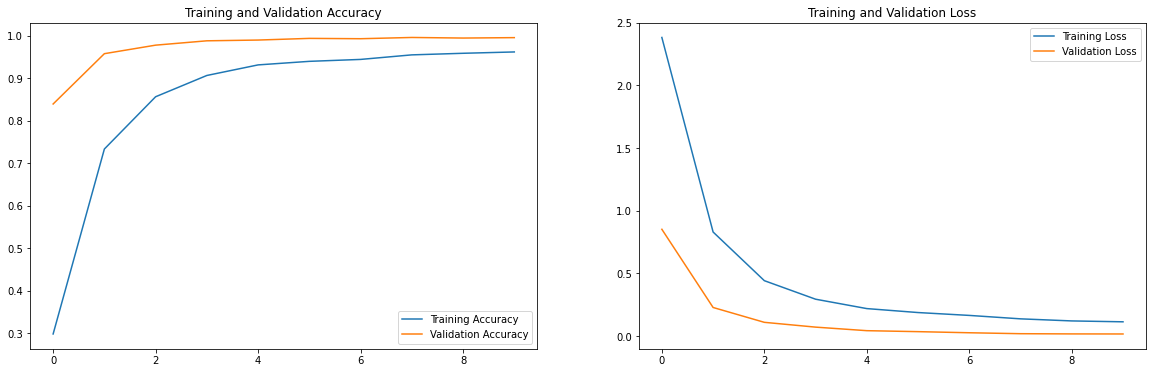

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### evaluate

In [21]:
model = results[0][0]

In [22]:
model.evaluate(validation_dataset)

80/80 [==============================] - 1s 16ms/step - loss: 0.0165 - accuracy: 0.9959


[0.016503609716892242, 0.9958710074424744]

In [23]:
predict_val = model.predict(validation_dataset).argmax(axis=1)
predict_val.shape, validation_label.shape

((5086,), (5086,))

In [24]:
predict_val[40:46], validation_label[40:46]

(array([10,  0,  7, 10, 29,  7]), 40    10.0
 41     0.0
 42     7.0
 43    10.0
 44    29.0
 45     7.0
 Name: 0, dtype: float32)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
# import seaborn as sns
# sns.heatmap(confusion_matrix(validation_label, predict_val), annot=True)

In [27]:
#Accuracy of the predicted values
print(classification_report(validation_label, predict_val)) 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       201
         1.0       1.00      1.00      1.00       201
         2.0       1.00      1.00      1.00       182
         3.0       0.98      1.00      0.99       140
         4.0       1.00      1.00      1.00       193
         5.0       0.99      0.97      0.98       198
         6.0       1.00      1.00      1.00       103
         7.0       1.00      0.99      1.00       207
         8.0       0.99      1.00      1.00       199
         9.0       0.99      1.00      1.00       151
        10.0       0.99      1.00      1.00       190
        11.0       0.99      1.00      1.00       182
        12.0       1.00      0.98      0.99       165
        13.0       0.99      1.00      1.00       196
        14.0       0.98      0.99      0.99       170
        15.0       1.00      1.00      1.00       142
        16.0       1.00      0.99      1.00       188
        17.0       1.00    